In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
#for ipynb
%matplotlib inline
import yaml

In [2]:
#get list of files with data
in_dirs = ['../TFBS_nucleosome_profiling_1000_to_20000sites/results',
           '../TFBS_nucleosome_profiling_30000sites/results',
          '../TFBS_nucleosome_profiling_50000sites/results']

samples_yaml = '../TFBS_nucleosome_profiling_30000sites/config/samples.GC.yaml'
tfx_path = '../../metadata/lung_validation/lung_tumor_fraction_data.txt'
metadata_path = '/fh/scratch/delete90/ha_g/realigned_bams/cfDNA_lung-cancer_EGA_hg38/metadata/scripts/lung_validation_cfDNA_metadata.tsv'

with open(samples_yaml, 'r') as f:
    samples = yaml.safe_load(f)
samples = samples['samples']
samples = list(samples.keys())  
print('samples:',len(samples))  

samples: 872


In [3]:
#get columns with coverage data
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [4]:
#import the metadata
metadata1 = pd.read_csv(metadata_path, sep='\t')
metadata1['status'] = np.where(metadata1['cancer_present']=='cancer',1,metadata1['cancer_present'])
metadata1['status'] = np.where(metadata1['status']=='no_cancer',0,metadata1['status'])

metadata2 = pd.read_csv(tfx_path, sep='\t')
metadata2 = metadata2[['sample','tumor_fraction']].set_index('sample') 
metadata = metadata1.merge(metadata2, on='sample')


metadata = metadata.rename(columns = {'tfx':'tumor_fraction','index':'sample'})


metadata_columns = ['sample', 'sample_type', 'Prior cancer', 'Future cancer',
       'Biopsy location', 'Stage','cohort', 'cancer_present',
       'group', 'status', 'tumor_fraction','file_id']

metadata = metadata[metadata_columns]
print("metadata samples:",len(metadata))

metadata samples: 850


In [5]:
for in_dir in in_dirs:
    in_files = []
    for sample in samples:
        in_files.append(in_dir+'/'+sample+'/'+sample+'.GC_corrected.coverage.tsv')
    print('files to import',len(in_files)) 
    
    #import data
    start_time = time.time()
    data = pd.DataFrame()
    for i,file in enumerate(in_files):
        if i%100==0:
            print(i,'importing',file,np.round(time.time()-start_time))
        current = pd.read_csv(file,sep='\t')
        data = data.append(current, ignore_index=True)

    #add site group
    data = data.rename(columns = {'sample':'file_id'})
    data['site_group'] = data['site_name'].str.rsplit('.',1,expand = True)[1]+'-sites'

    #merge with data
    data = data.merge(metadata, on = 'file_id')
    data['Stage'] = data['Stage'].str.strip('ABC')
    print('data with metadata:')
    print(len(data['site_name'].unique()))
    print(len(data['sample'].unique()))
    print(len(data))
    print(len(data['site_name'].unique())*len(data['sample'].unique()))
    print(data['number_of_sites'].unique())
    
    #get the key columns
    data = data[metadata_columns+['site_name','correction','site_group',
                                  'central_coverage','amplitude','mean_coverage']+str_plot_columns]
    site_groups = data['site_group'].unique()

    #export each site group
    for group,df in data.groupby('site_group'):
        print(group,len(df['site_name'].unique()))

        df.to_csv('merged_data/'+group+'_data_with_features.txt', sep='\t', index=False)

        #reformat for logistic regression
        reformatted = df[metadata_columns+['site_name','site_group','central_coverage','amplitude','mean_coverage']]
        reformatted = reformatted.set_index(metadata_columns+['site_group','site_name']).unstack()
        new_column_names = []
        for item in reformatted.columns.values:
            new_column_names.append('_'.join(item))
        reformatted.columns = new_column_names

        LUCAS = reformatted[(reformatted.index.get_level_values('group') == 'LUCAS_cancer') | (reformatted.index.get_level_values('group') == 'LUCAS_healthy')]
        validation = reformatted[(reformatted.index.get_level_values('group') == 'validation_cancer') | (reformatted.index.get_level_values('group') == 'validation_healthy')]

        LUCAS.to_csv('merged_data/'+group+'_LUCAS_reformatted.txt', sep='\t')
        validation.to_csv('merged_data/'+group+'_validation_reformatted.txt', sep='\t')

        print(LUCAS.shape)
        print(validation.shape)


files to import 872
0 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005322788/EGAF00005322788.GC_corrected.coverage.tsv 0.0
100 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005322859/EGAF00005322859.GC_corrected.coverage.tsv 6.0
200 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005322852/EGAF00005322852.GC_corrected.coverage.tsv 18.0
300 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005323099/EGAF00005323099.GC_corrected.coverage.tsv 35.0
400 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005323152/EGAF00005323152.GC_corrected.coverage.tsv 58.0
500 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005322721/EGAF00005322721.GC_corrected.coverage.tsv 87.0
600 importing ../TFBS_nucleosome_profiling_1000_to_20000sites/results/EGAF00005323503/EGAF00005323503.GC_corrected.coverage.tsv 122.0
700 importing ../TFBS_nucleosome_profiling_1000_to_2

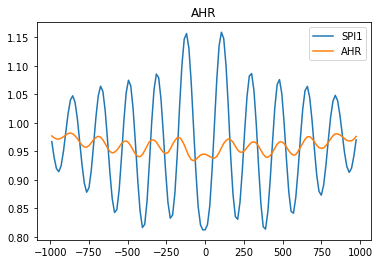

In [6]:
#plot
for site_name in ['SPI1','AHR']:
    current = data[data['site_name'].str.contains(site_name)][str_plot_columns].mean()
    plt.plot(plot_columns,current, label=site_name)
    plt.title(site_name)
    #plt.show()
plt.legend()



fft real -0.29800990132287775
fft imag -0.15860996593214188
fft magn 0.3375900214453421
sum x coords -0.29800990132289185
sum y coords -0.1586099659321641
magnitude: 0.337590021445365


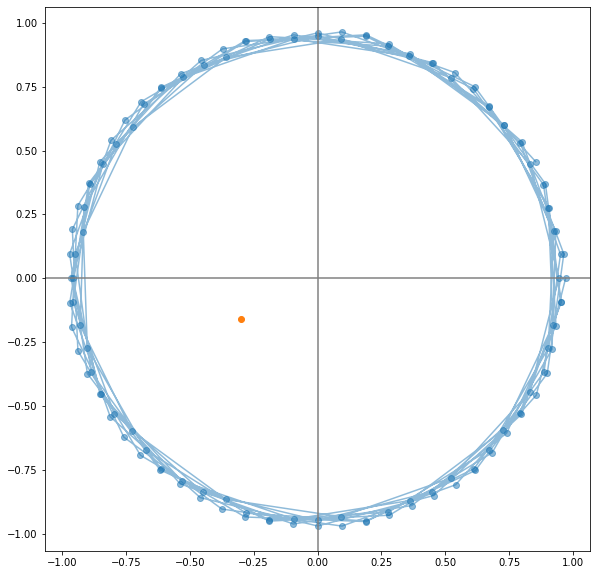

In [7]:
fft_columns = np.arange(-960,960,15)
str_fft_columns = [str(m) for m in fft_columns]

#plot out what the fft is doing for a given frequency
demo_res = np.fft.fft(current[str_fft_columns])
demo_signal = current[str_fft_columns]

frequency = 10
print('fft real', demo_res[frequency].real)
print('fft imag', demo_res[frequency].imag)
print('fft magn',np.abs(demo_res[frequency]))

#get angles for rotation
angles = np.linspace(0,2*np.pi,len(demo_signal)+1)
angles = -angles[0:-1]

#wrapped at frequency
heights = np.sin(angles*frequency)*demo_signal
widths = np.cos(angles*frequency)*demo_signal
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(widths,heights, alpha = 0.5)
ax.scatter(widths,heights, alpha = 0.5)
ax.set_aspect('equal')
ax.scatter(sum(widths),sum(heights))
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
print('sum x coords',sum(widths))
print('sum y coords',sum(heights))
print('magnitude:',np.sqrt(sum(widths)**2+sum(heights)**2))

In [8]:
# from scipy.signal import find_peaks
# plt.plot(fft_columns,current)
# peaks =  [fft_columns[m] for m in find_peaks(current)[0]]
# plt.scatter(peaks,[.99 for m in peaks])
# print(peaks)

# spacing = []
# for i in range(len(peaks)-1):
#     spacing.append(peaks[i+1]-peaks[i])
# np.mean(spacing)

In [9]:
# test = data[data['group']=='LUCAS_cancer'][['sample','tumor_fraction']].drop_duplicates()
# len(test[test['tumor_fraction']>0.05])
# len(test[(test['tumor_fraction']<0.05) & (test['tumor_fraction']>0.0)])
# len(test[(test['tumor_fraction']==0.0)])

In [1]:
287-129

158

In [2]:
91+67

158